# pySCENIC (scRNA-seq based)
[pySCENIC](https://www.nature.com/articles/s41596-020-0336-2) [1] is a package containing different statistical methods to extract biological activities from scRNA-seq data within a unified framework, including gene regulatory network inference and transcription factor activity inference. We follow [the instruction](https://pyscenic.readthedocs.io/en/latest/installation.html) to install pySCENIC. pySCENIC depends on packages e.g. arboreto and ctxcore. In this notebook (integrated from [this example](https://pyscenic.readthedocs.io/en/latest/tutorial.html) and [this example](https://github.com/aertslab/pySCENIC/blob/master/notebooks/pySCENIC%20-%20Full%20pipeline.ipynb)) we show how to use [pySCENIC](https://pyscenic.readthedocs.io/en/latest/) for TF activity inference with only the gene expression matrix. 

[1] Van de Sande, Bram, et al. "A scalable SCENIC workflow for single-cell gene regulatory network analysis." _Nature Protocols_ 15.7 (2020): 2247-2276.

**IMPORTANT** 
- To install and use pySCENIC, we recommend creating a new conda environment as instructed.
- Before running pySCENIC, download the [resources and databases](https://resources.aertslab.org/cistarget/) first.
![alt text](https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs41596-020-0336-2/MediaObjects/41596_2020_336_Fig1_HTML.png?as=webp)

(Image is linked from [here](https://www.nature.com/articles/s41596-020-0336-2/figures/1).) 

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import glob, os, pickle, time, scipy, sys

from arboreto.utils import load_tf_names
from arboreto.algo import grnboost2
from ctxcore.rnkdb import FeatherRankingDatabase as RankingDatabase
from pyscenic.utils import modules_from_adjacencies, load_motifs
from pyscenic.prune import prune2df, df2regulons
from pyscenic.aucell import aucell

import session_info
session_info.show()

## Preliminary work

### Loading the scRNA-seq data
For this tutorial, we will analyze a scRNA-seq data consists in 3k peripheral blood mononuclear cells (PBMCs) from a Healthy Donor which is freely available from [10x Genomics](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k). The following command downloads 5.9 MB of data upon the first call and stores it in `data/pbmc3k_raw.h5ad`. Basic preprocessing workflow can be found [here](https://scanpy.readthedocs.io/en/stable/tutorials/basics/clustering-2017.html).

In [2]:
adata = sc.datasets.pbmc3k()
adata.var_names_make_unique()
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata

AnnData object with n_obs × n_vars = 2700 × 13714
    obs: 'n_genes'
    var: 'gene_ids', 'n_cells'

Extract the count matrix.

In [3]:
ex_matrix = adata.to_df()

In [4]:
ex_matrix.head()

index,AL627309.1,AP006222.2,RP11-206L10.2,RP11-206L10.9,LINC00115,NOC2L,KLHL17,PLEKHN1,RP11-54O7.17,HES4,...,MT-ND4L,MT-ND4,MT-ND5,MT-ND6,MT-CYB,AC145212.1,AL592183.1,AL354822.1,PNRC2-1,SRSF10-1
index,,,,,,,,,,,,,,,,,,,,,
AAACATACAACCAC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,10.0,1.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
AAACATTGAGCTAC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,33.0,1.0,0.0,8.0,0.0,1.0,0.0,0.0,0.0
AAACATTGATCAGC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,2.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
AAACCGTGCTTCCG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,3.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
AAACCGTGTATGCG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


### Loading the list of transcription factors (for Phase I)
Load the list of human TFs, which can be downloaded from [here](https://github.com/aertslab/pySCENIC/blob/master/resources/hs_hgnc_tfs.txt).

In [5]:
tf_names = load_tf_names('resources_pyscenic/allTFs_hg38.txt')

### Loading the ranking databases (for Phase II)
Load the ranking databases, which can be downloaded from [here](https://resources.aertslab.org/cistarget/databases/homo_sapiens/hg38/refseq_r80/mc_v10_clust/gene_based/).

In [11]:
db_fnames = glob.glob('resources_pyscenic/*rankings.feather')
def name(fname):
    return os.path.splitext(os.path.basename(fname))[0]
dbs = [RankingDatabase(fname=fname, name=name(fname)) for fname in db_fnames]

## Phase I: Inference of co-expression modules
In the initial phase of the pySCENIC pipeline the single cell expression profiles are used to infer co-expression modules. 
### Inference of co-expression modules
Given a predefined list of TFs, regulatory interactions between these factors and putative target genes are inferred via regression-based network inference from the expression or count matrix.

In [6]:
adjacencies = grnboost2(ex_matrix, tf_names=tf_names, verbose=True)

preparing dask client
parsing input
creating dask graph
4 partitions
computing dask graph


C:\Users\linan\anaconda3\envs\pyscenic\lib\site-packages\distributed\client.py:3162: UserWarning: Sending large graph of size 147.74 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


shutting down client and local cluster
finished


The output is a list of adjacencies connecting a TF with a target gene. A weight or importance is associated with these connections to distinguish strong from weak regulatory interactions.

In [7]:
adjacencies.head()

,TF,target,importance
541,CREM,ZNF397,15.678602
1188,ZNF584,PLEKHJ1,14.567152
1158,ZNF749,ARL6IP1,14.068097
1158,ZNF749,SIPA1,13.205364
747,SIN3A,RP11-18H21.1,12.085783


In [8]:
!mkdir outputs_pyscenic
adjacencies.to_csv('outputs_pyscenic/adjacencies.csv', index=False)

A subdirectory or file outputs_pyscenic already exists.


### Derivation of potential regulomes
Regulons are derived from adjacencies based on three methods:
- Based on the top N targets for each factor, with a default of 50 targets.
- Based on the top N regulators for a target; the default settings select sets of 5, 10, and 50 regulators.
- Based on a percentile score; the default is to select sets based on the 75th or 90th percentile of a factor’s targets.

In [9]:
modules = modules_from_adjacencies(adjacencies, ex_matrix,
    # according to pyscenic warning
    # this masks all 0 expression entries for a particular gene for the correlation computation
    rho_mask_dropouts = True)


2024-06-25 13:10:01,409 - pyscenic.utils - INFO - Calculating Pearson correlations.

2024-06-25 13:10:03,462 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [True].

2024-06-25 13:10:23,795 - pyscenic.utils - INFO - Creating modules.


These modules are defined by the name of the regulator (TF), the list of target genes, the method of generation and the mode of transcriptional control (activation or repression). 

In [10]:
modules[0]

Regulon(name='Regulon for ABCF2', gene2weight=frozendict.frozendict({'UNK': 2.4528316959894676, 'MKS1': 2.1475636400538445, 'PKNOX1': 2.065509344322646, 'ABRACL': 1.3905465833461594, 'GPX7': 1.145719692654647, 'ATPAF2': 0.9656040017274732, 'DNTTIP2': 0.9470409243415527, 'EXOC1': 0.9392959762272748, 'CGGBP1': 0.9240670123081465, 'RXRB': 0.8187277949875573, 'IPCEF1': 0.8122990589910071, 'SRRM1': 0.721037562251876, 'WDR62': 0.6819045698594383, 'KPNA3': 0.6762115350434068, 'RSL24D1': 0.6545854785975477, 'TSFM': 0.6329405539412526, 'CLP1': 0.6029882456789754, 'ACAT1': 0.568227558139157, 'ZNF544': 0.5423386575477245, 'ECH1': 0.5350283566306914, 'COPB1': 0.5088997402459973, 'NARF': 0.5032575110342103, 'EIF4A3': 0.4937562507691361, 'ORMDL3': 0.46417117459101165, 'JAKMIP1': 0.4318847649278132, 'ABCF2': 1.0}), gene2occurrence=frozendict.frozendict({}), transcription_factor='ABCF2', context=frozenset({'weight>75.0%', 'activating'}), score=0.0, nes=0.0, orthologous_identity=0.0, similarity_qvalue=

## Phase II: Prune modules for targets with cis regulatory footprints
Calculate a list of enriched motifs and the corresponding target genes for all modules. The motif-to-TF annotation file can be download from [here](https://resources.aertslab.org/cistarget/motif2tf/).

In [13]:
motif_annotation_file = 'resources_pyscenic/motifs-v10nr_clust-nr.hgnc-m0.001-o0.0.tbl'
df = prune2df(dbs, modules, motif_annotation_file)

The output is a table including scores from the ranking and recovery procedure (the area under the curve AUC and the normalized enrichment score NES), annotations, and an abbreviated list of the target genes with their network importance scores.

In [14]:
df.head()

Enrichment                                  \
                                AUC       NES MotifSimilarityQvalue   
TF     MotifID                                                        
ARID3A tfdimers__MD00373   0.128860  3.327122          7.607130e-06   
       tfdimers__MD00361   0.135050  3.529616          3.066610e-06   
       tfdimers__MD00541   0.145249  3.863272          1.871020e-06   
       tfdimers__MD00070   0.142330  3.767778          2.920990e-08   
       tfdimers__MD00097   0.162482  4.427035          1.749130e-09   

                                              \
                         OrthologousIdentity   
TF     MotifID                                 
ARID3A tfdimers__MD00373                 1.0   
       tfdimers__MD00361                 1.0   
       tfdimers__MD00541                 1.0   
       tfdimers__MD00070                 1.0   
       tfdimers__MD00097                 1.0   

                                                                             \
                                                                 Annotation   
TF     MotifID                                                                
ARID3A tfdimers__MD00373  gene is annotated for similar motif tfdimers__...   
       tfdimers__MD00361  gene is annotated for similar motif tfdimers__...   
       tfdimers__MD00541  gene is annotated for similar motif tfdimers__...   
       tfdimers__MD00070  motif similar to tfdimers__MD00014 ('M01835_re...   
       tfdimers__MD00097  gene is annotated for similar motif tfdimers__...   

                                                                             \
                                                                    Context   
TF     MotifID                                                                
ARID3A tfdimers__MD00373  frozenset({'weight>75.0%', 'activating', 'hg38...   
       tfdimers__MD00361  frozenset({'weight>75.0%', 'activating', 'hg38...   
       tfdimers__MD00541  frozenset({'weight>75.0%', 'activating', 'hg38...   
       tfdimers__MD00070  frozenset({'weight>75.0%', 'activating', 'hg38...   
       tfdimers__MD00097  frozenset({'weight>75.0%', 'activating', 'hg38...   

                                                                             \
                                                                TargetGenes   
TF     MotifID                                                                
ARID3A tfdimers__MD00373  [('XAF1', 1.898548420043347), ('FGD3', 1.17894...   
       tfdimers__MD00361  [('ARID3A', 1.0), ('TMEM176B', 1.3874657025103...   
       tfdimers__MD00541  [('FGD3', 1.1789493132027973), ('ARID3A', 1.0)...   
       tfdimers__MD00070  [('TMEM176B', 1.3874657025103159), ('ARID3A', ...   
       tfdimers__MD00097  [('FGD3', 1.1789493132027973), ('TMEM176B', 1....   

                                    
                         RankAtMax  
TF     MotifID                      
ARID3A tfdimers__MD00373      1273  
       tfdimers__MD00361       917  
       tfdimers__MD00541       725  
       tfdimers__MD00070       255  
       tfdimers__MD00097       291

**IMPORTANT** Save and reload the motifs to proceed successfully.

In [15]:
df.to_csv('outputs_pyscenic/motifs.csv')
df_motifs = load_motifs('outputs_pyscenic/motifs.csv')

In [17]:
df_motifs.head()

Enrichment                                  \
                                AUC       NES MotifSimilarityQvalue   
TF     MotifID                                                        
ARID3A tfdimers__MD00373   0.128860  3.327122          7.607130e-06   
       tfdimers__MD00361   0.135050  3.529616          3.066610e-06   
       tfdimers__MD00541   0.145249  3.863272          1.871020e-06   
       tfdimers__MD00070   0.142330  3.767778          2.920990e-08   
       tfdimers__MD00097   0.162482  4.427035          1.749130e-09   

                                              \
                         OrthologousIdentity   
TF     MotifID                                 
ARID3A tfdimers__MD00373                 1.0   
       tfdimers__MD00361                 1.0   
       tfdimers__MD00541                 1.0   
       tfdimers__MD00070                 1.0   
       tfdimers__MD00097                 1.0   

                                                                             \
                                                                 Annotation   
TF     MotifID                                                                
ARID3A tfdimers__MD00373  gene is annotated for similar motif tfdimers__...   
       tfdimers__MD00361  gene is annotated for similar motif tfdimers__...   
       tfdimers__MD00541  gene is annotated for similar motif tfdimers__...   
       tfdimers__MD00070  motif similar to tfdimers__MD00014 ('M01835_re...   
       tfdimers__MD00097  gene is annotated for similar motif tfdimers__...   

                                                                             \
                                                                    Context   
TF     MotifID                                                                
ARID3A tfdimers__MD00373  (weight>75.0%, activating, hg38_10kbp_up_10kbp...   
       tfdimers__MD00361  (weight>75.0%, activating, hg38_10kbp_up_10kbp...   
       tfdimers__MD00541  (weight>75.0%, activating, hg38_10kbp_up_10kbp...   
       tfdimers__MD00070  (weight>75.0%, activating, hg38_10kbp_up_10kbp...   
       tfdimers__MD00097  (weight>75.0%, activating, hg38_10kbp_up_10kbp...   

                                                                             \
                                                                TargetGenes   
TF     MotifID                                                                
ARID3A tfdimers__MD00373  [(XAF1, 1.898548420043347), (FGD3, 1.178949313...   
       tfdimers__MD00361  [(ARID3A, 1.0), (TMEM176B, 1.3874657025103159)...   
       tfdimers__MD00541  [(FGD3, 1.1789493132027973), (ARID3A, 1.0), (T...   
       tfdimers__MD00070  [(TMEM176B, 1.3874657025103159), (ARID3A, 1.0)...   
       tfdimers__MD00097  [(FGD3, 1.1789493132027973), (TMEM176B, 1.3874...   

                                    
                         RankAtMax  
TF     MotifID                      
ARID3A tfdimers__MD00373      1273  
       tfdimers__MD00361       917  
       tfdimers__MD00541       725  
       tfdimers__MD00070       255  
       tfdimers__MD00097       291

This dataframe can then be converted to regulons.

In [18]:
regulons = df2regulons(df_motifs)

Create regulons from a dataframe of enriched features.
Additional columns saved: []


The sets of predicted direct target genes across all modules sharing the same regulator are combined into a single resulting regulon. Only the genes that make up the leading edge of a motif annotated for the factor are retained in the final predicted regulon.

In [19]:
regulons[0]

Regulon(name='ACAA1(+)', gene2weight=frozendict.frozendict({'PLSCR1': 1.5975052466254942, 'ARSG': 2.4215197155951964, 'PRNP': 0.6555315095968346, 'FGFRL1': 0.9215833148360923, 'LYPLAL1': 3.461812597743842, 'EID2': 1.4548959627598625, 'SAMSN1': 0.9719854845955695, 'ARRDC1': 1.0044975640183293, 'TRIQK': 1.079147249185368, 'MFSD12': 0.09393808097061576, 'PLEC': 0.5123604553081723, 'SLC31A2': 0.5806152128684436, 'RASGEF1B': 0.3746381775251262, 'MARCKS': 0.7673626064473366, 'MAPKAPK2': 0.5274861865486666}), gene2occurrence=frozendict.frozendict({}), transcription_factor='ACAA1', context=frozenset({'metacluster_67.2.png', 'activating'}), score=2.153074609022575, nes=0.0, orthologous_identity=0.0, similarity_qvalue=0.0, annotation='')

## Phase III: Cellular regulon enrichment matrix
To quantify the activity of these predicted regulons in the individual cells, `aucell` calculates the recovery of the predicted targetome of a factor on the expression abundance-based ranked list of genes in a cell. Enrichment of a regulon is measures as AUC of the recovery curve of the genes that define this regulon.

In [20]:
auc_mtx = aucell(ex_matrix, regulons, noweights = True)

In [21]:
auc_mtx.to_csv('outputs_pyscenic/auc.csv')

Visualize the TF activity matrix.

C:\Users\linan\anaconda3\envs\pyscenic\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
C:\Users\linan\anaconda3\envs\pyscenic\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


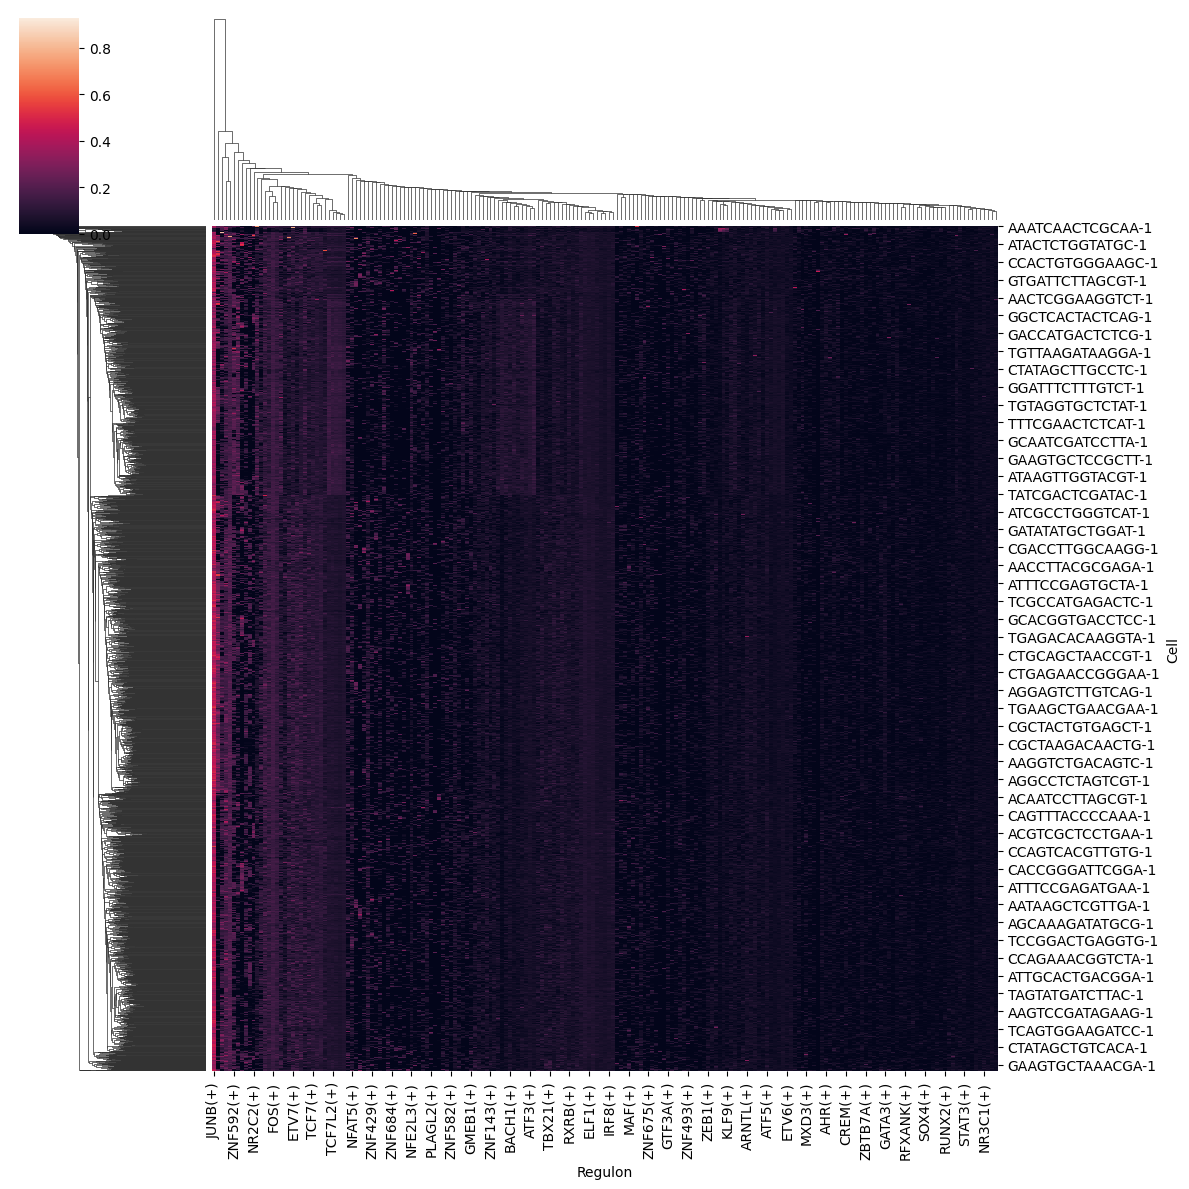

In [22]:
sns.clustermap(auc_mtx, figsize=(12,12))